In [11]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data

from tqdm import tnrange, tqdm_notebook
import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# to restart layer numbering
from keras import backend as K
K.clear_session()

In [2]:
save_path = 'C:/Users/320060820/experiments/test_models/'

In [3]:
def test_data_inference_noise(model, test_data, num_splits=10):
    
    acc = []
    split_index = test_data[0].shape[0] // num_splits
    assert split_index * num_splits == test_data[0].shape[0]
    
    original_acc = model.evaluate(test_data[0], test_data[1], verbose=0)[1]
    
    for i in range(1, num_splits+1):
        t_x = test_data[0][(i-1)*split_index:i*split_index]
        t_y = test_data[1][(i-1)*split_index:i*split_index]
        acc.append(model.evaluate(t_x, t_y, verbose=0)[1])
    acc = np.array(acc)
    
    diff =  (original_acc - acc)
    per_diff =  (original_acc - acc) / original_acc
    
    print('Full test set accuracy:', original_acc)
    print('Accuracy for the 10 folds of test set:', acc)
    print('Difference:', diff)
    print('% Difference:', per_diff)
    
    return acc, original_acc, diff, per_diff

In [4]:
def brute_force_analysis_weights(model, layer_names, bw_range, f_range, fix_quant=False, parameters=None, 
                         eval_metric='acc_drop'):
    
    if fix_quant and parameters is None:
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_quant:
                    #fix quantization for certain layers
                    model = fix_weights_quantization(model, parameters)

                model.model = fxp_quantize.quantize_weights(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i])
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
        
    model.load_model_from_path()
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [15]:
def plot_results(scores, layer_names, rows, columns, figsize, shrink, bw_range, f_range, invert=False, vmax=None):
    
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
#         sns.heatmap(scores[:, :, i], annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])

In [5]:
# config
save_path = 'C:/Users/320060820/experiments/test_models/'
bw_range = np.arange(1, 11, 1)
f_range = np.arange(1, 11, 1)
layer_names = [f'conv2d_{i}' for i in range(1, 5)] + ['dense_1']
vmax=0.1

In [8]:
name = 'mnist_keras'
model_path = 'mnist_custom/mnist_keras.h5'

from test_models.mnist_custom import data
_, test_data = data.get_data()

# keras_mnist = model_data.Model(name, test_data, path=save_path+model_path)

In [12]:
# Run brute force for multiple splits of the dataset
num_splits = 5
split_index = test_data[0].shape[0] // num_splits
assert split_index * num_splits == test_data[0].shape[0]

scores_list = []
for i in range(1, num_splits+1):
    t_x = test_data[0][(i-1)*split_index:i*split_index]
    t_y = test_data[1][(i-1)*split_index:i*split_index]
    
    model_obj = model_data.Model(name, (t_x, t_y), path=save_path + model_path)
    s = brute_force_analysis_weights(model_obj, layer_names[:2], bw_range, f_range)
    scores_list.append(s)
    print(f'split {i} of {num_splits + 1} done')

Layer conv2d_1 done.


Layer conv2d_2 done.
split 1 of 6 done


Layer conv2d_1 done.


Layer conv2d_2 done.
split 2 of 6 done


Layer conv2d_1 done.


Layer conv2d_2 done.
split 3 of 6 done


Layer conv2d_1 done.


Layer conv2d_2 done.
split 4 of 6 done


Layer conv2d_1 done.


Layer conv2d_2 done.
split 5 of 6 done


In [24]:
layer_1_s = scores_list[0][:, :, 0].copy()
layer_2_s = scores_list[0][:, :, 1].copy()
for s in scores_list[1:]:
    layer_1_s = np.dstack((layer_1_s, s[:, :, 0].copy()))
    layer_2_s = np.dstack((layer_2_s, s[:, :, 1].copy()))    

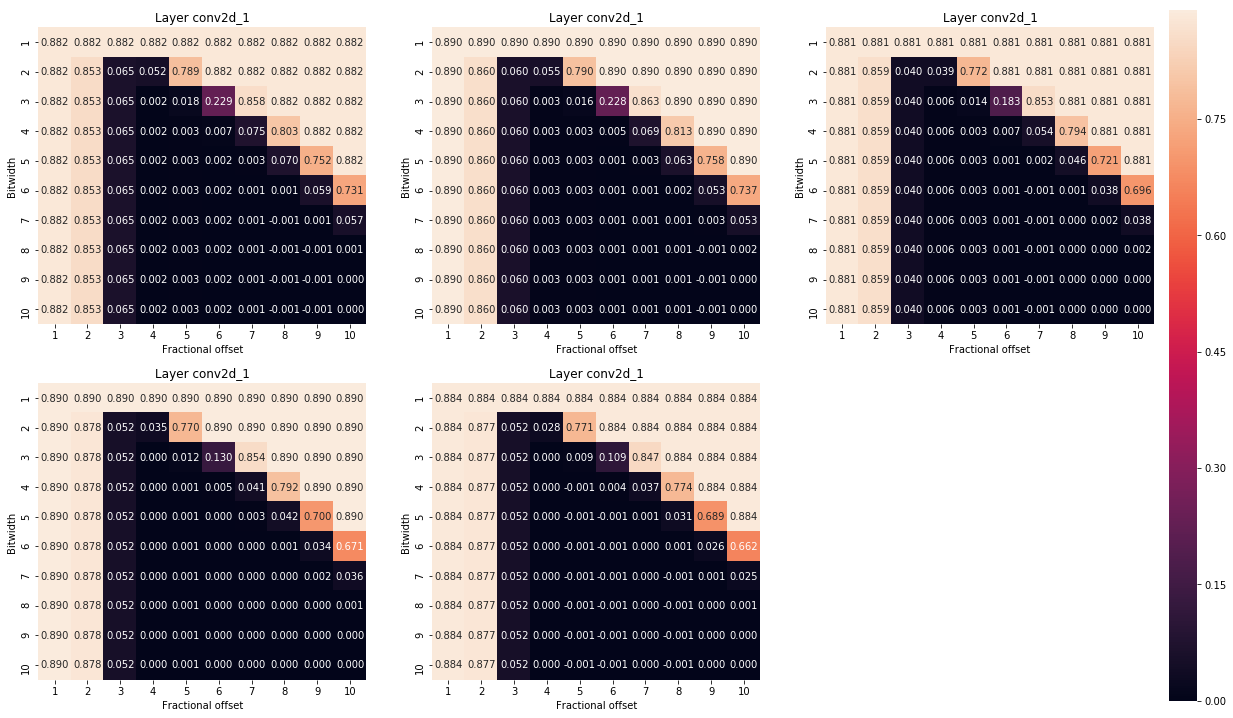

In [28]:
plot_results(layer_1_s, layer_names[:1] * 5, 2, 3, (20, 12), 0.8, bw_range, f_range)

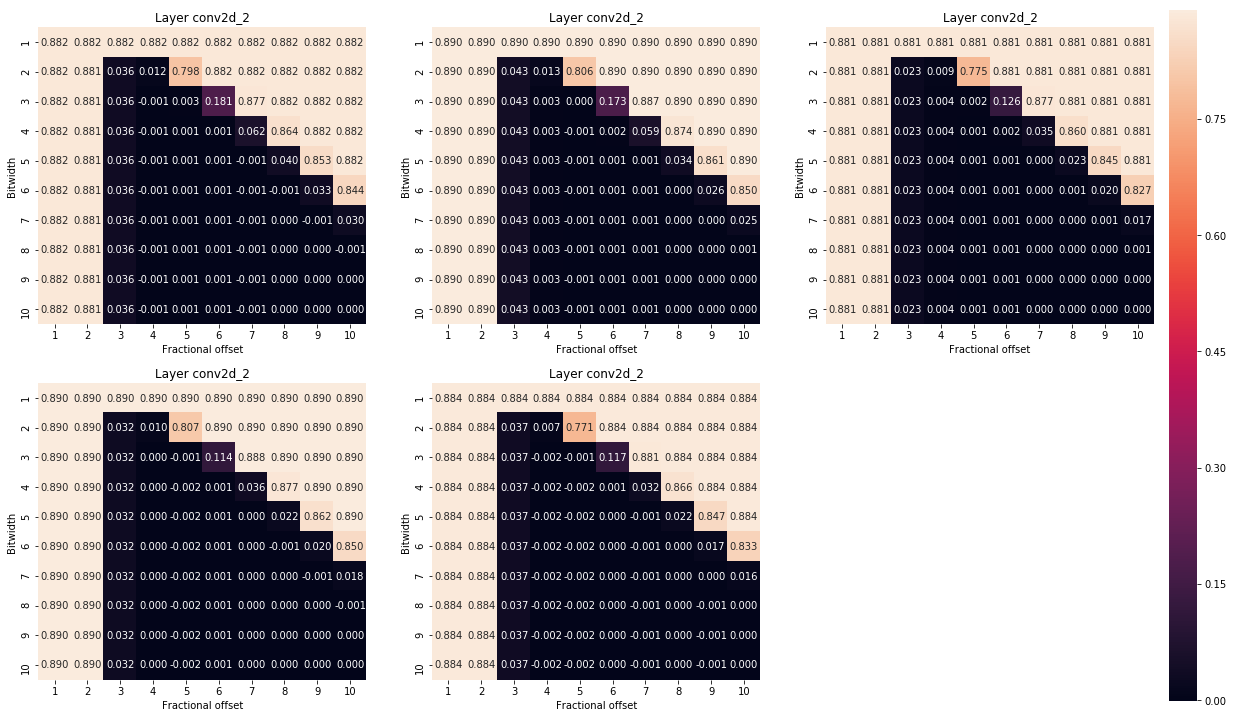

In [29]:
plot_results(layer_2_s, layer_names[1:2] * 5, 2, 3, (20, 12), 0.8, bw_range, f_range)